<a href="https://www.kaggle.com/code/wamaithanyamu/cisco-timeseries-model-applied-to-stocks-forex-c?scriptVersionId=286517759" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [45]:
!pip install gitpython yfinance torch pandas numpy matplotlib

In [46]:
import os
import git

# Define the target directory path
repo_path = '/kaggle/working/cisco-time-series-model'
repo_url = 'https://github.com/splunk/cisco-time-series-model.git'

# Check if the directory exists
if os.path.isdir(repo_path):
    print(f"Directory '{repo_path}' already exists. Skipping clone.")
else:
    print(f"Directory '{repo_path}' not found. Cloning repository...")
    try:
        git.Repo.clone_from(repo_url, repo_path)
        print("Cloning complete.")
    except git.exc.GitCommandError as e:
        print(f"Error during cloning: {e}")

Directory '/kaggle/working/cisco-time-series-model' already exists. Skipping clone.


In [47]:
import sys
sys.path.append('/kaggle/working/cisco-time-series-model')

In [48]:
!pip install -r "/kaggle/working/cisco-time-series-model/requirements.txt"

In [49]:
!touch /kaggle/working/cisco-time-series-model/__init__.py


In [50]:
import sys
import os

# 1. Define the directory that CONTAINS the package folder
# This is /kaggle/working/
parent_dir = os.path.abspath('/kaggle/working/')

# 2. Add this parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

print(f"Added {parent_dir} to sys.path.")

Added /kaggle/working to sys.path.


In [51]:
import sys
import os

# Define the folder that CONTAINS the 'modeling' module
module_parent_dir = os.path.abspath('/kaggle/working/cisco-time-series-model/1.0-preview')

# Add this specific directory to sys.path
if module_parent_dir not in sys.path:
    sys.path.append(module_parent_dir)

# Now, you can import 'modeling' directly
from modeling import (
    CiscoTsmMR,
    TimesFmHparams,
    TimesFmCheckpoint
)

print("Successfully imported classes by correcting the path and structure.")

Successfully imported classes by correcting the path and structure.


In [52]:
import torch
import yfinance as yf
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Union
import pandas as pd
import numpy as np

# 💻 Determine device (CPU or CUDA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🌍 Running on device: {DEVICE}")


🌍 Running on device: cpu


# Deriv API Configs

Deriv broker offers a handful of snthetically generated assets and I thought it would be good to see how this model performs on assets that are computer generated. Can this model pick up the under;ying patterns that power the synthetic generator?

To get your APP ID and token please follow this [guide](https://docs.google.com/document/d/1R0nvI5nL_-pqkqSJCsdvU0_xzFqbiwhpDr74mkuLtqo/edit?usp=sharing)

In [71]:
# kaggle secrets here if on kaggle

from kaggle_secrets import UserSecretsClient

# ---------------------------------------------------------
# 🔑 DERIV API CONSTANTS
# ---------------------------------------------------------

try:
    # Initialize the secrets client
    secrets = UserSecretsClient()

    # Get the main secret string (assuming the token is stored as the primary secret)
    DEFAULT_TOKEN = secrets.get_secret("deriv_api")
    print("🔑 Deriv Token loaded securely.")

    # Get a custom secret key (assuming the App ID is stored as a custom key 'app_id')
    # Note: KaggleSecrets returns strings, so it must be converted to an integer.
    APP_ID = int(secrets.get_secret("deriv_app_id"))
    print("🆔 Deriv App ID loaded securely.")

except Exception as e:
    # Fallback to placeholders if running outside Kaggle or secret is missing/incorrect
    print(f"⚠️ Warning: Failed to load secrets from Kaggle ({e}). Falling back to dummy values.")
    APP_ID = 1234
    DEFAULT_TOKEN = "YOUR-TOKEN-GOES-HERE"





🔑 Deriv Token loaded securely.
🆔 Deriv App ID loaded securely.


In [54]:
# =========================================================
# 🔗 NEW DATA SOURCE: Deriv API Client for OHLC
# =========================================================
import asyncio
import json
import ssl
import time
import os
import sys
from collections import deque, Counter
from decimal import Decimal, InvalidOperation
import certifi
import websockets
from concurrent.futures import Future
import threading

class DerivOHLCFetcher:
    """A minimal Deriv WS client to fetch historical OHLC (candle) data."""

    def __init__(self, token: str, app_id: int):
        self.token = token
        self.app_id = app_id
        self.uri = f"wss://ws.derivws.com/websockets/v3?app_id={app_id}"
        # 🔒 Secure connection setup
        # self.ssl_context = ssl.create_default_context(cafile=certifi.where()) 
        self.resp_queue = asyncio.Queue()
        self.ws = None

    async def connect_and_authorize(self):
        """Connects, authorizes, and returns the websocket object."""
        try:
            print("🔗 Connecting securely to Deriv WebSocket...")
            self.ws = await websockets.connect(self.uri,  open_timeout=10)
            
            # Start a background reader for responses
            self.reader_task = asyncio.create_task(self._reader_loop())
            
            await self.ws.send(json.dumps({"authorize": self.token}))
            
            # Wait for authorization response
            msg = await asyncio.wait_for(self.resp_queue.get(), timeout=10)
            
            if "error" in msg:
                print(f"💥 Authorization error: {msg['error'].get('message')}")
                return False
            
            print(f"✅ Authorized! Login ID: {msg['authorize'].get('loginid')}")
            return True
        
        except Exception as e:
            print(f"❌ Connection/Authorization failed: {e}")
            return False

    async def _reader_loop(self):
        """Reads frames and pushes parsed JSON into resp_queue."""
        try:
            async for raw in self.ws:
                msg = json.loads(raw)
                # Only queue relevant responses (authorize, error, candles)
                if isinstance(msg, dict) and any(k in msg for k in ("authorize", "error", "candles")):
                    await self.resp_queue.put(msg)
        except Exception:
            # 🧹 Cleanly stop the reader loop
            pass 

    async def fetch_ohlc(self, symbol: str, granularity: int, count: int) -> pd.DataFrame | None:
        """Fetches historical OHLC data and converts it to a pandas DataFrame."""
        if not await self.connect_and_authorize():
            return None

        # Request payload using 'ticks_history' for candles or ticks
        # when no gransurality is supplied or is less than 60, we assume the user wants to use ticks
        if granularity >=60:
            payload = {
                "ticks_history": symbol,
                "count": count,
                "end": "latest",
                "style": "candles",
                "granularity": granularity
            }
        else:
             payload = {
                "ticks_history": symbol,
                "count": count,
                "end": "latest",
                "style": "ticks"
                
            }
            
        print(f"⏳ Requesting {count} {granularity // 60}-minute candles for {symbol}...")
        await self.ws.send(json.dumps(payload))
        
        try:
            # Wait for response
            resp = await asyncio.wait_for(self.resp_queue.get(), timeout=30)
            
            if "error" in resp:
                print(f"💥 API Error on request: {resp['error'].get('message')}")
                return None
            
            # Candles data is extracted directly from the 'candles' key
            if granularity >= 60:
                candles = resp.get('candles', []) 
                df = pd.DataFrame(candles)
            else:
                candles = resp.get('prices', [])
                times = resp.get('times',[])
                data = {
                        'epoch': times,
                        'close': candles
                    }
                    
                    # ⚙️ Creating the DataFrame
                df = pd.DataFrame(data)
                            
            if not candles:
                print("⚠️ No candles returned from API.")
                return None
            
            print(f"✅ Loaded {len(candles)} candles.")
            
            # Convert to DataFrame
           
            df['date'] = pd.to_datetime(df['epoch'], unit='s')
            df.set_index('date', inplace=True)
            # 🎯 The model requires "Close" price, which is 'close' in the API response
            df['Close'] = df['close'] 
            df.sort_index(inplace=True)
            
            return df[['Close']].copy()

        except Exception as e:
            print(f"❌ Error during OHLC fetch: {e}")
            return None
        finally:
            # 🔌 Clean up connection
            if self.ws:
                await self.ws.close()
            if self.reader_task:
                 self.reader_task.cancel()


# =========================================================
# 💡 KAGGLE/NOTEBOOK ASYNC FIX HELPER FUNCTION
# =========================================================

def _sync_fetch_ohlc_threaded(fetcher, symbol, granularity, count):
    """Executes the async fetcher in a new thread with its own event loop."""
    print("⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...")
    
    def run_async_in_thread(future_obj):
        new_loop = asyncio.new_event_loop()
        asyncio.set_event_loop(new_loop)
        try:
            result = new_loop.run_until_complete(fetcher.fetch_ohlc(
                symbol=symbol,
                granularity=granularity,
                count=count
            ))
            future_obj.set_result(result)
        finally:
            new_loop.close()

    future = Future()
    thread = threading.Thread(target=run_async_in_thread, args=(future,))
    thread.start()
    thread.join() # Wait for the thread to complete its work
    return future.result()


# Core functionality

In [55]:
class CiscoTsmModel:
    """
    A class to fetch financial data (yfinance/Deriv), initialize the CiscoTsmMR
    (TimesFM) model, and generate and plot forecasts.
    """
    def __init__(self, ticker: str, start_date: str, end_date: str, zoom_bars: int = 50, prediction_length: int = 76, future_length: int = 51, deriv: bool = False, count: int = 5000, tf: int = 60):
        # 📥 Data Parameters (Unchanged)
        self.TICKER = ticker
        self.START_DATE = start_date
        self.END_DATE = end_date
        self.DERIV_OR_YFINANCE = deriv
        self.GRANULARITY = tf
        self.COUNT = count

        # 💾 Data Storage (Unchanged)
        self.historical_data = None 
        self.data = None 
        self.close: Optional[np.ndarray] = None # Close prices array

        # ⚙️ Model Parameters (Unchanged)
        self.zoom_bars: int = zoom_bars
        self.prediction_length = prediction_length
        self.future_length = future_length
        
        # 🤖 CiscoTsmMR Model Initialization (NEW)
        self.model: CiscoTsmMR = self._initialize_cisco_model()
        
        print(f"\n✨ Initialized CiscoTsm Forecaster for {self.TICKER} ({self.START_DATE} to {self.END_DATE}).")

    def _initialize_cisco_model(self) -> CiscoTsmMR:
        """Initializes the CiscoTsmMR model with predefined hyperparameters and checkpoint."""
        
        # Hyperparameters (Using the same values as your dummy code)
        hparams = TimesFmHparams(
            num_layers=50,
            use_positional_embedding=False,
            backend="gpu" if torch.cuda.is_available() else "cpu",
        )

        # Checkpoint
        ckpt = TimesFmCheckpoint(huggingface_repo_id="cisco-ai/cisco-time-series-model-1.0-preview")

        # Model instance
        model = CiscoTsmMR(
            hparams=hparams,
            checkpoint=ckpt,
            use_resolution_embeddings=True,
            use_special_token=True,
        )
        print("🤖 CiscoTsmMR model loaded successfully.")
        return model

    # --- Data Loading Methods (Modified for simplicity and compatibility) ---

    def load_data(self) -> bool:
        """Step 1: Download data and preprocess (yfinance)."""
        print(f"📥 Loading data for {self.TICKER} from yfinance...")
        
        df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)
        if df.empty:
            print(f"❌ Error: No data found for {self.TICKER}. Exiting.")
            return False
            
        self.historical_data = df.copy()
        
        if "Close" not in df.columns: # Changed check to Close for simplicity
            print("❌ Error: 'Close' price data is missing.")
            return False
            
        self.data = df[["Open", "Close"]].copy() 
        self.data.columns = [f"{self.TICKER}_Open", f"{self.TICKER}_Close"]
        
        # 📈 Extract Close prices as the main series (required for TimesFM context)
        # Ensure it is a contiguous numpy array of float32, as expected by TimesFM
        self.close = self.data[f"{self.TICKER}_Close"].values.astype(np.float32)
        return True

    def load_deriv_data(self) -> bool:
        """Step 1: Fetch OHLC data from Deriv and preprocess."""
        print(f"📥 Fetching {self.GRANULARITY // 60}-minute OHLC data for {self.TICKER} from Deriv...")
        
        fetcher = DerivOHLCFetcher(DEFAULT_TOKEN, APP_ID) 
        ohlc_data = None
        
        try:
            ohlc_data = _sync_fetch_ohlc_threaded(
                fetcher, self.TICKER, self.GRANULARITY, self.COUNT
            )
        except Exception as e:
            print(f"💥 Fatal error during data fetching: {e}")
            return False

        if ohlc_data is None or ohlc_data.empty:
            print(f"❌ Error: No data found for {self.TICKER}. Exiting.")
            return False

        # Assuming ohlc_data is a DataFrame and has a 'Close' column
        if "Close" not in ohlc_data.columns:
             print(f"❌ Error: 'Close' price data is missing in Deriv data.")
             return False

        # 🎯 Prepare data (Extracting Close prices as the main series)
        # Ensure it is a contiguous numpy array of float32, as expected by TimesFM
        self.close = ohlc_data["Close"].values.astype(np.float32)
        return True

    # --- Core Methods ---
    
    def make_predictions(self):
        """
        Splits data, makes the forecast using CiscoTsmMR, and plots the results.
        
        NOTE: CiscoTsmMR returns a list of dictionaries, which must be unpacked.
        """
        if self.close is None:
            print("❌ Error: Data not loaded. Cannot make predictions.")
            return

        print(f"Total data points: {len(self.close)}")
        
        # 1. Split data into context (ctx) and true future values (future)
        # The split point is based on self.future_length
        split_index = len(self.close) - self.future_length
        ctx_s: np.ndarray
        future_s: np.ndarray
        try:
            ctx_s, future_s = np.split(self.close, [split_index])
        except ValueError:
            print(f"❌ Error: Not enough data points ({len(self.close)}) to split into context and future (requires at least {self.future_length + 1}).")
            return

        print(f"Context length: {len(ctx_s)}. Future length: {len(future_s)}.")

        # 2. Model Inference using CiscoTsmMR's forecast method
        # It expects the context as a NumPy array (or list of arrays)
        forecast_preds: List[Dict[str, Union[np.ndarray, Dict[float, np.ndarray]]]]
        
        # CiscoTsmMR only returns quantiles/mean up to `prediction_length`.
        # The `horizon_len` argument in the Cisco model is equivalent to the old `prediction_length`
        forecast_preds = self.model.forecast(ctx_s, horizon_len=self.prediction_length)
        
        # 3. Process the forecast output
        # forecast_preds is a list of results (one per series, here just one)
        first_series_result = forecast_preds[0]
        
        # The original plot_forecast expects a tensor of quantiles (index-based)
        # We need to restructure the dictionary output into a structured tensor for plotting.
        
        # Get the keys (quantiles) and sort them: [0.1, 0.2, 0.3, 0.5, ..., 0.9]
        quantile_levels = sorted(first_series_result['quantiles'].keys())
        
        # Stack the quantile NumPy arrays into a single PyTorch tensor (N x 9)
        # The original code expected a tensor where index 4 is the median (0.5), and 0/8 are bounds.
        # Ensure the quantile levels match what the plotting function expects (e.g., 9 levels from 0.1 to 0.9)
        
        # The original plot_forecast assumed 9 quantiles (0.1 to 0.9)
        # Let's map the dictionary values to the required index in the tensor
        quantiles_list = [first_series_result['quantiles'][level] for level in quantile_levels]
        
        # Convert the list of NumPy arrays to a single PyTorch tensor (T x Q)
        # T is prediction_length, Q is number of quantiles (e.g., 9)
        quantiles_tensor = torch.from_numpy(np.stack(quantiles_list, axis=1)) 
        
        # 4. Plot the forecast
        # Pass the context (ctx_s), the restructured quantile tensor, and the true future values (future_s)
        self.plot_forecast(ctx_s, quantiles_tensor, future_s)


    def plot_forecast(self, ctx: np.ndarray, quantile_fc: torch.Tensor, real_future_values: Optional[np.ndarray] = None):
        """
        Plot forecasted quantiles alongside real context and optional future values.
        Uses a two-subplot structure: Main view and Zoomed view.
        
        NOTE: This method remains largely unchanged and expects the quantiles as a (T, 9) tensor.
        """
        
        # Extract quantiles based on expected tensor structure (index 4 is median) 🎯
        median_forecast = quantile_fc[:, 4].numpy()
        lower_bound = quantile_fc[:, 0].numpy()
        upper_bound = quantile_fc[:, 8].numpy()

        # 🧭 X-axis ranges 
        original_x = range(len(ctx))
        forecast_start_index = len(ctx)
        forecast_x = range(forecast_start_index, forecast_start_index + len(median_forecast))
        print(f"➡️ Non-overlapping forecast: forecast_x starts at {forecast_start_index}")

        # 🎨 Setup figure with two subplots
        fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})
        fig.suptitle(f"({self.TICKER}) CiscoTsm Forecast + Zoomed (Last {self.zoom_bars} Bars + Full Forecast)", fontsize=14, weight="bold")

        # -----------------------------
        # 🧩 Plot 1: Main Forecast Plot
        # -----------------------------
        axs[0].plot(original_x, ctx, label="Ground Truth Context", color="#4a90d9")
        if real_future_values is not None:
            original_fut_x = range(len(ctx), len(ctx) + len(real_future_values))
            axs[0].plot(original_fut_x, real_future_values, label="Ground Truth Future", color="#4a90d9", linestyle=":")
            
        axs[0].plot(forecast_x, median_forecast, label="Forecast (Median)", color="#d94e4e", linestyle="--")
        axs[0].fill_between(
            forecast_x, lower_bound, upper_bound, color="#d94e4e", alpha=0.1, label="Forecast 10% - 90% Quantiles"
        )
        
        axs[0].set_xlim(left=0)
        axs[0].legend()
        axs[0].grid(True)
        axs[0].set_title("Main Forecast View 🌍")
        
        # Optional connector line 🤝
        axs[0].plot(
            [len(ctx) - 1, forecast_start_index],
            [ctx[-1], median_forecast[0]],
            color="#999", linestyle=":", alpha=0.6
        )

        # --------------------------------
        # 🔎 Plot 2: Zoomed-In Forecast 
        # --------------------------------
        
        # 1. Calculate the starting index for the zoomed plot. 
        zoom_start = max(0, len(ctx) - self.zoom_bars)
        
        # 2. Define the X-axis and Y-axis data for the context part of the zoom.
        zoom_context_x = range(zoom_start, len(ctx))
        context_data_to_show = ctx[zoom_start:] 

        # 3. Define the X-axis limit for the end of the zoomed plot (full prediction).
        zoom_end = forecast_x[-1] + 1 

        # Context (Last N bars) 📊
        axs[1].plot(zoom_context_x, context_data_to_show, color="#4a90d9", label=f"Recent Context (Last {len(context_data_to_show)})")
        
        # Real future (if available) - plotted starting at len(ctx)
        if real_future_values is not None:
            original_fut_x = range(len(ctx), len(ctx) + len(real_future_values))
            axs[1].plot(original_fut_x, real_future_values, color="#4a90d9", linestyle=":", label="Ground Truth Future")
            
        # Forecast 🔮
        axs[1].plot(forecast_x, median_forecast, color="#d94e4e", linestyle="--", label="Forecast (Median)")
        axs[1].fill_between(forecast_x, lower_bound, upper_bound, color="#d94e4e", alpha=0.1, label="Forecast 10% - 90% Quantiles")
        
        # Set X limits to ensure both history buffer and full prediction are visible.
        axs[1].set_xlim(zoom_start, max(zoom_start, zoom_end))
        axs[1].grid(True)
        axs[1].legend()
        axs[1].set_title(f"({self.TICKER}) Zoomed Forecast Region (Last {self.zoom_bars} Bars + Full Forecast) 🔍")
        
        plt.tight_layout()
        plt.show()
        print(f"✅ Plotted main and zoomed forecast views (last {self.zoom_bars} bars + full forecast) successfully! 🚀")

    def run_forecast(self):
        """Execute the full forecasting pipeline."""
        print("The deriv setting is ", self.DERIV_OR_YFINANCE)
        if self.DERIV_OR_YFINANCE:
            if self.load_deriv_data():
                print("Loadded data from deriv")
            else:
                print("❌ Failed to load deriv data. Exiting.")
                return
        else:
            if self.load_data():
                print("Loadded data from yfinance")
            else:
                print("❌ Failed to load yfinance data. Exiting.")
                return
        print("***"*10)
        print("Startiing predictions")
        print("***"*10)
        self.make_predictions()

# Run all forecasts function

In [56]:
END_DATE ="2025-12-31"
START_DATE = "2012-01-01"

In [57]:
from typing import Optional
import datetime

def run_single_asset_forecast(
    ticker: str, 
    start_date:str=START_DATE, 
    end_date:str=END_DATE,
    zoom_bars: int = 50, 
    prediction_length: int = 76,  
    future_length: int = 51,      
    deriv: bool = False,          # Flag to switch data source
    count: int = 5000,            # Number of bars to fetch (Deriv only)
    tf: int = 60                  # Timeframe in seconds (Deriv only)
):
    """
    Runs a single asset price forecasting model using the CiscoTsmModel,
    allowing data fetching from either YFinance (default) or Deriv.
    
    Args:
        ticker (str): Asset ticker symbol (e.g., 'AAPL', 'VIX10').
        start_date (str): Start date for data fetching (YYYY-MM-DD format).
        end_date (str): End date for data fetching (YYYY-MM-DD format).
        zoom_bars (int): Number of recent bars to show in the zoomed plot view.
        prediction_length (int): The length of the forecast horizon.
        future_length (int): Number of actual future data points to reserve for validation/plotting.
        deriv (bool): If True, use Deriv data fetching logic; otherwise, use yfinance.
        count (int): Bar count for Deriv fetching.
        tf (int): Timeframe in seconds for Deriv fetching.
    """

    # ⚙️ Prepare keyword arguments for the model's __init__
    kwargs = {
        'zoom_bars': zoom_bars,
        'prediction_length': prediction_length,
        'future_length': future_length,
        'deriv': deriv, 
        'count': count, 
        'tf': tf
    }
    
    data_source = "Deriv" if deriv else "YFinance"
    print(f"\n--- 🏭 Starting CiscoTsmModel run for Ticker: {ticker} ({data_source}) ---")

    try:
        # 🌟 Create the forecaster instance 
        forecaster = CiscoTsmModel(
            ticker,          
            start_date,      
            end_date,        
            **kwargs,
        )
        
        # 🏃 Run the forecast (The model internally checks the 'deriv' flag)
        forecaster.run_forecast()
        
        print(f"✅ Run for {ticker} completed successfully.")
        
    except NameError as e:
        print(f"❌ Error in RUN: CiscoTsmModel class or dependencies not found. Details: {e}")
    except Exception as e:
        print(f"💔 Error during execution for {ticker}: {e}")
        
    print(f"--- 🏁 Run for {ticker} concluded. ---")


# APPLE


--- 🏭 Starting CiscoTsmModel run for Ticker: AAPL (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for AAPL (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for AAPL from yfinance...


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 3509
Context length: 3458. Future length: 51.
➡️ Non-overlapping forecast: forecast_x starts at 3458


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


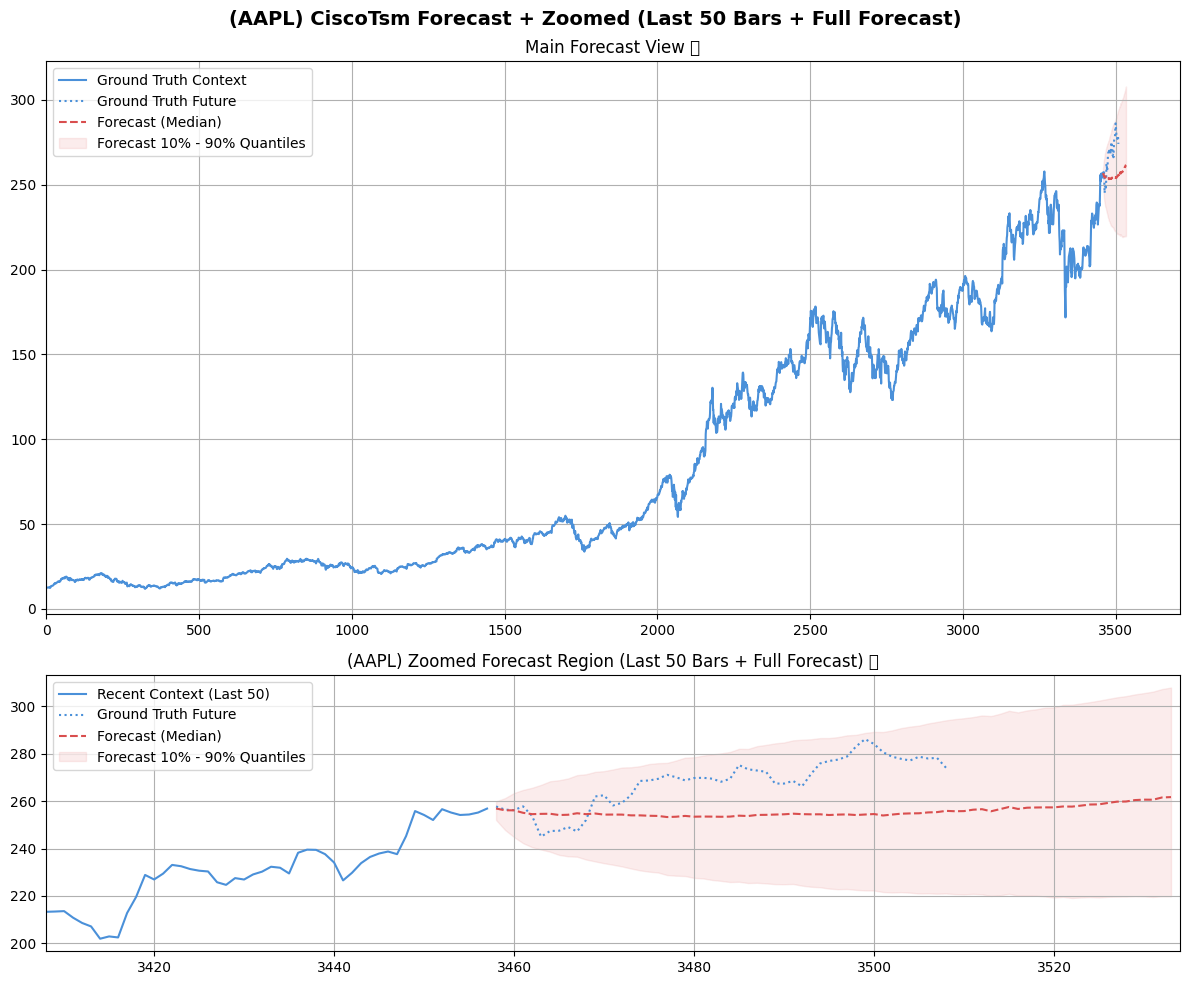

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for AAPL completed successfully.
--- 🏁 Run for AAPL concluded. ---


In [58]:
run_single_asset_forecast('AAPL')

# GOOGLE


--- 🏭 Starting CiscoTsmModel run for Ticker: GOOGL (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for GOOGL (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for GOOGL from yfinance...


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 3509
Context length: 3458. Future length: 51.
➡️ Non-overlapping forecast: forecast_x starts at 3458


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


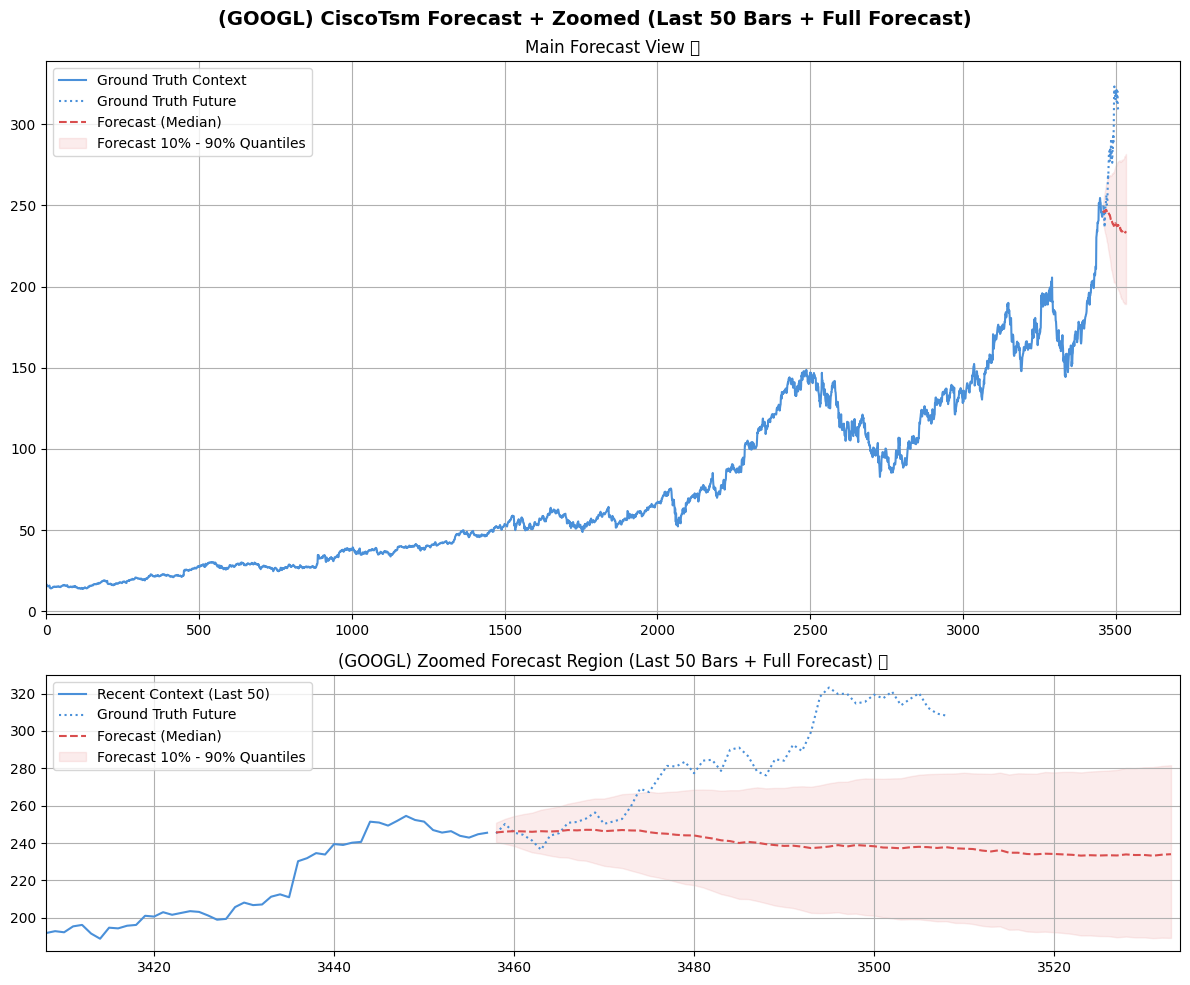

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for GOOGL completed successfully.
--- 🏁 Run for GOOGL concluded. ---


In [59]:
run_single_asset_forecast('GOOGL')

# AMAZON


--- 🏭 Starting CiscoTsmModel run for Ticker: AMZN (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for AMZN (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for AMZN from yfinance...
Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 3509
Context length: 3458. Future length: 51.


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


➡️ Non-overlapping forecast: forecast_x starts at 3458


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


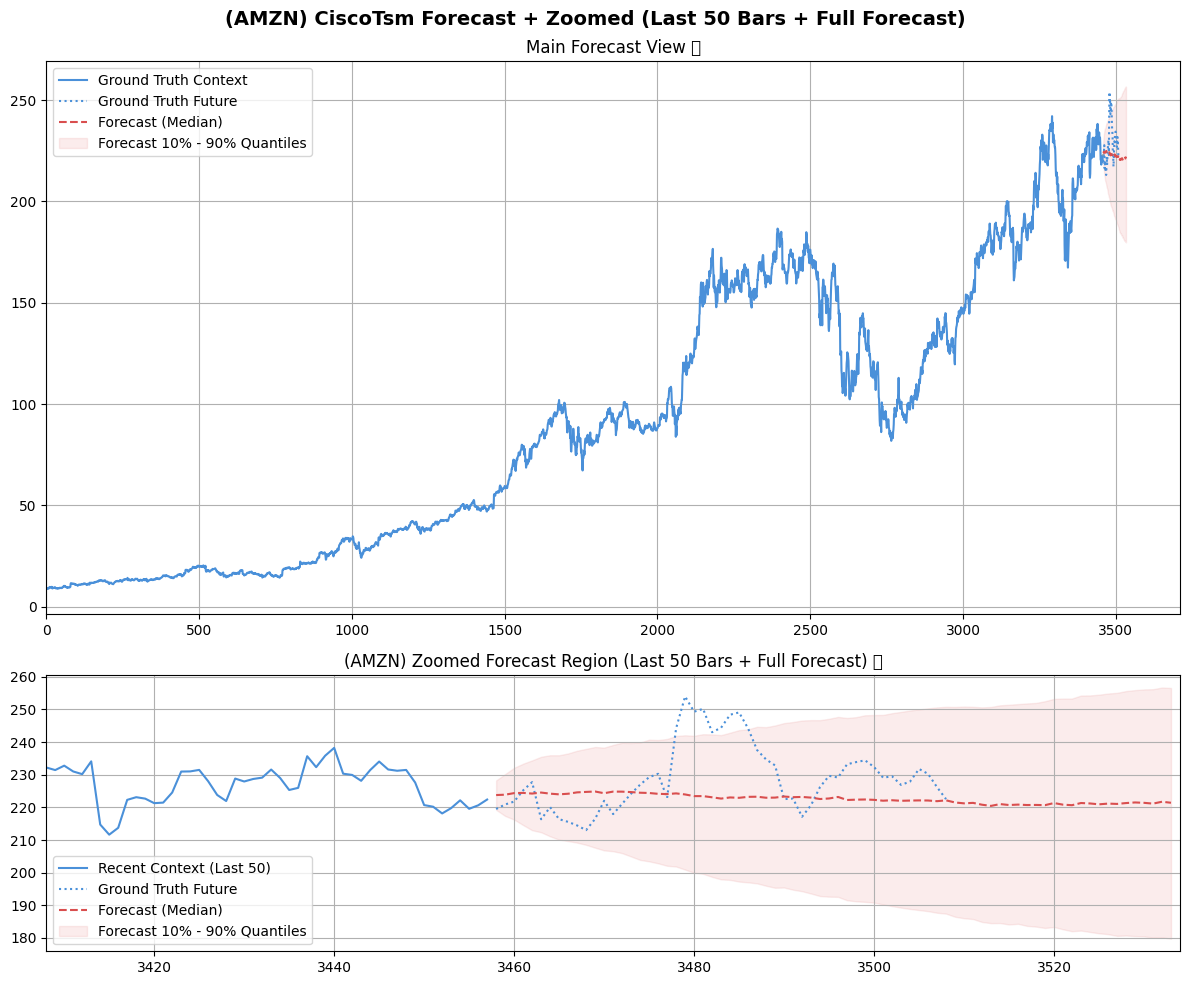

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for AMZN completed successfully.
--- 🏁 Run for AMZN concluded. ---


In [60]:
run_single_asset_forecast('AMZN')

# MICROSOFT


--- 🏭 Starting CiscoTsmModel run for Ticker: MSFT (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for MSFT (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for MSFT from yfinance...


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 3509
Context length: 3458. Future length: 51.
➡️ Non-overlapping forecast: forecast_x starts at 3458


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


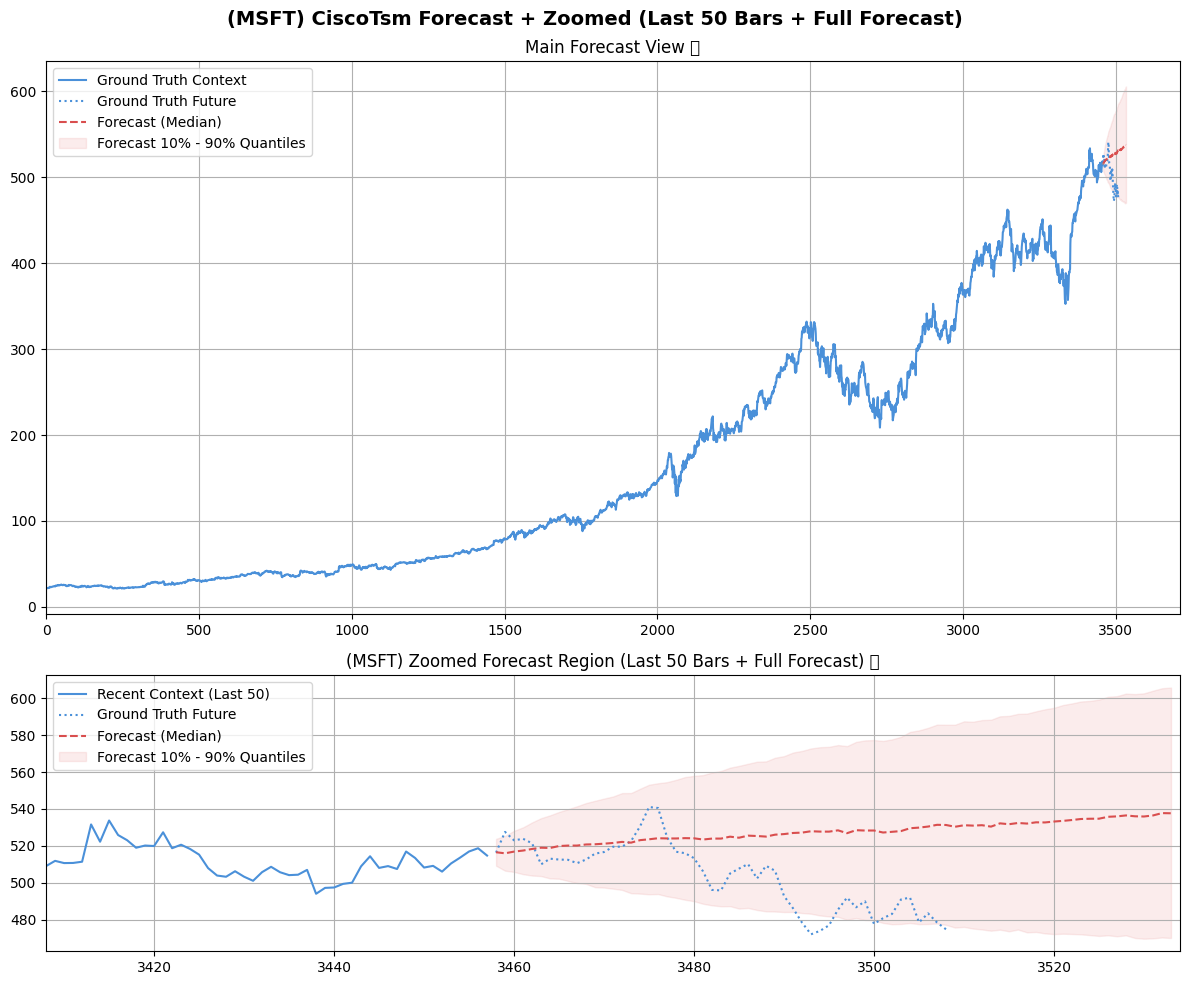

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for MSFT completed successfully.
--- 🏁 Run for MSFT concluded. ---


In [61]:
run_single_asset_forecast('MSFT')

# EURUSD


--- 🏭 Starting CiscoTsmModel run for Ticker: EURUSD=X (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for EURUSD=X (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for EURUSD=X from yfinance...
Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 3634
Context length: 3583. Future length: 51.


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


➡️ Non-overlapping forecast: forecast_x starts at 3583


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


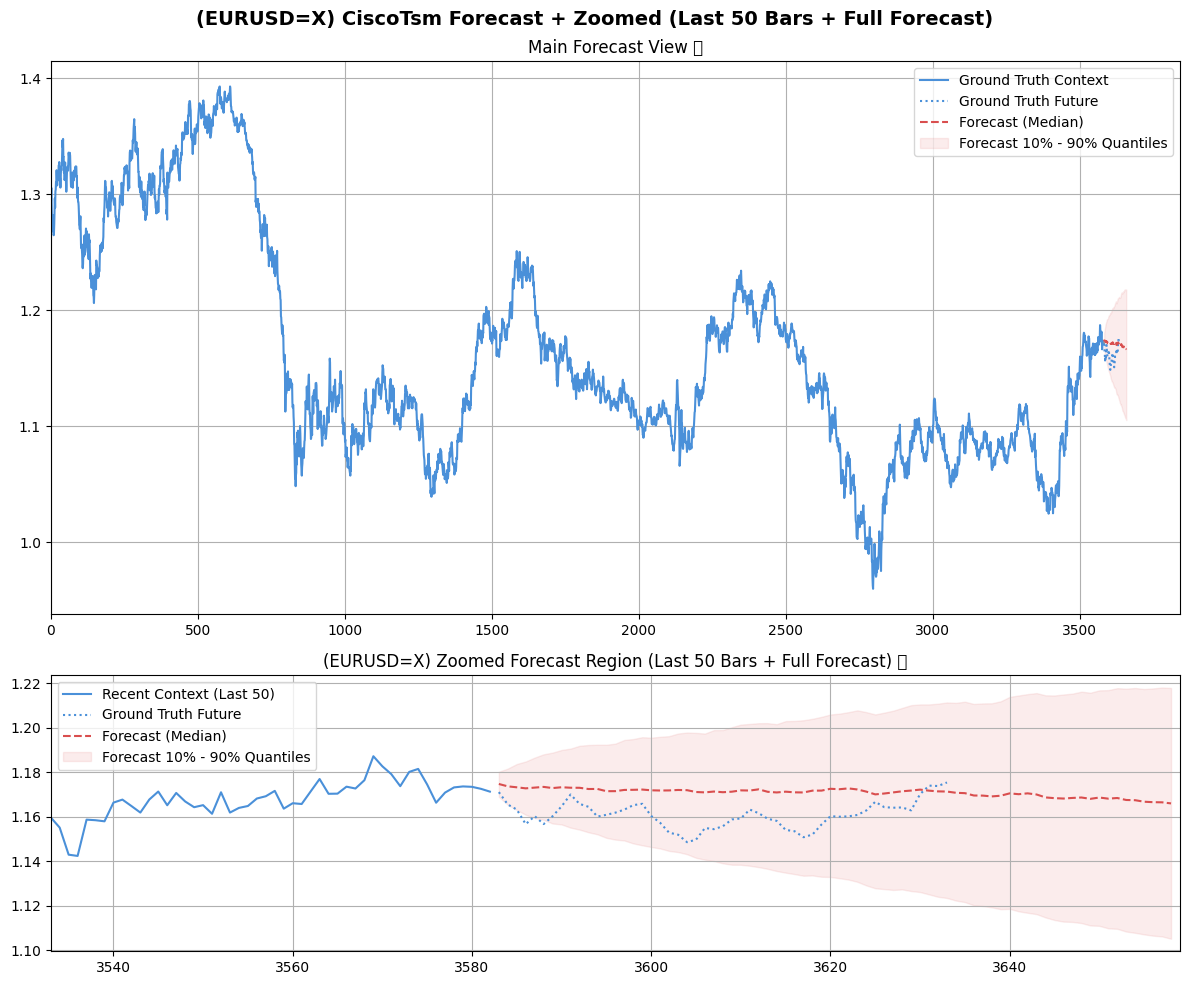

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for EURUSD=X completed successfully.
--- 🏁 Run for EURUSD=X concluded. ---


In [62]:

TICKER = 'EURUSD=X'
run_single_asset_forecast(TICKER)

# GBPUSD


--- 🏭 Starting CiscoTsmModel run for Ticker: GBPUSD=X (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for GBPUSD=X (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for GBPUSD=X from yfinance...


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 3635
Context length: 3584. Future length: 51.
➡️ Non-overlapping forecast: forecast_x starts at 3584


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


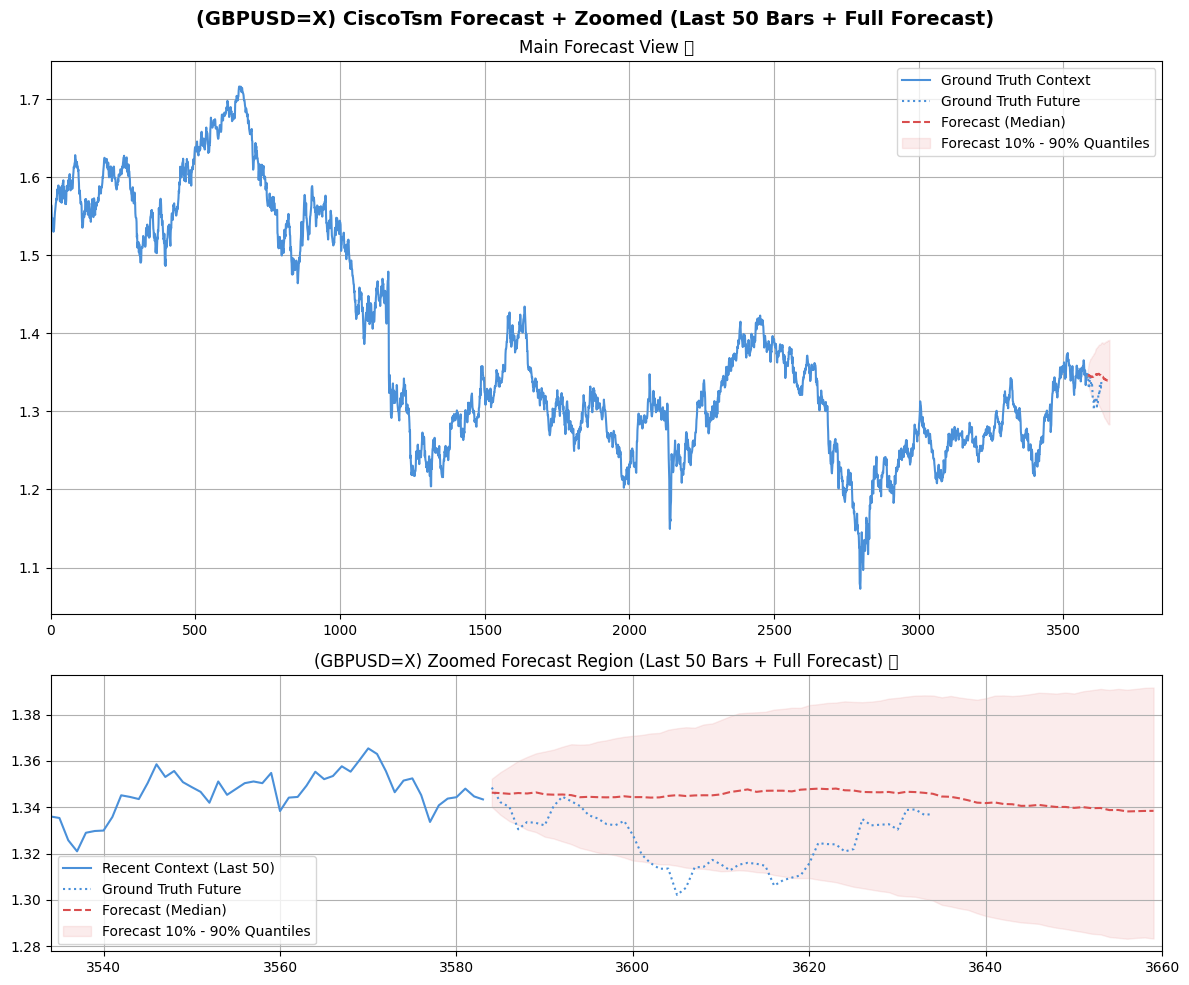

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for GBPUSD=X completed successfully.
--- 🏁 Run for GBPUSD=X concluded. ---


In [63]:
TICKER = 'GBPUSD=X'
run_single_asset_forecast(TICKER)

# USDJPY


--- 🏭 Starting CiscoTsmModel run for Ticker: USDJPY=X (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for USDJPY=X (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for USDJPY=X from yfinance...


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 3635
Context length: 3584. Future length: 51.
➡️ Non-overlapping forecast: forecast_x starts at 3584


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


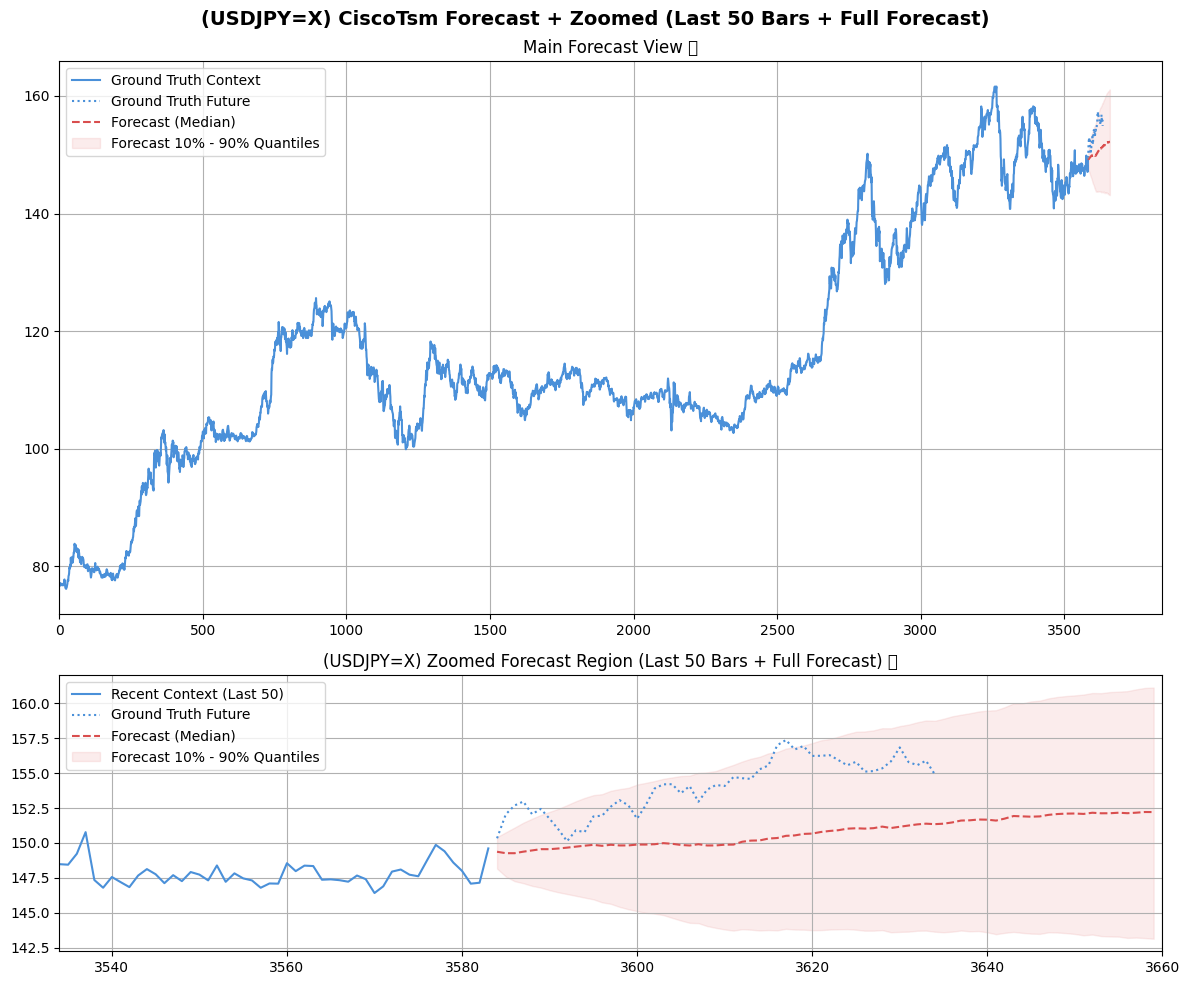

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for USDJPY=X completed successfully.
--- 🏁 Run for USDJPY=X concluded. ---


In [64]:
TICKER = 'USDJPY=X'
run_single_asset_forecast(TICKER)

# BTC-USD


--- 🏭 Starting CiscoTsmModel run for Ticker: BTC-USD (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for BTC-USD (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for BTC-USD from yfinance...


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 4109
Context length: 4058. Future length: 51.
➡️ Non-overlapping forecast: forecast_x starts at 4058


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


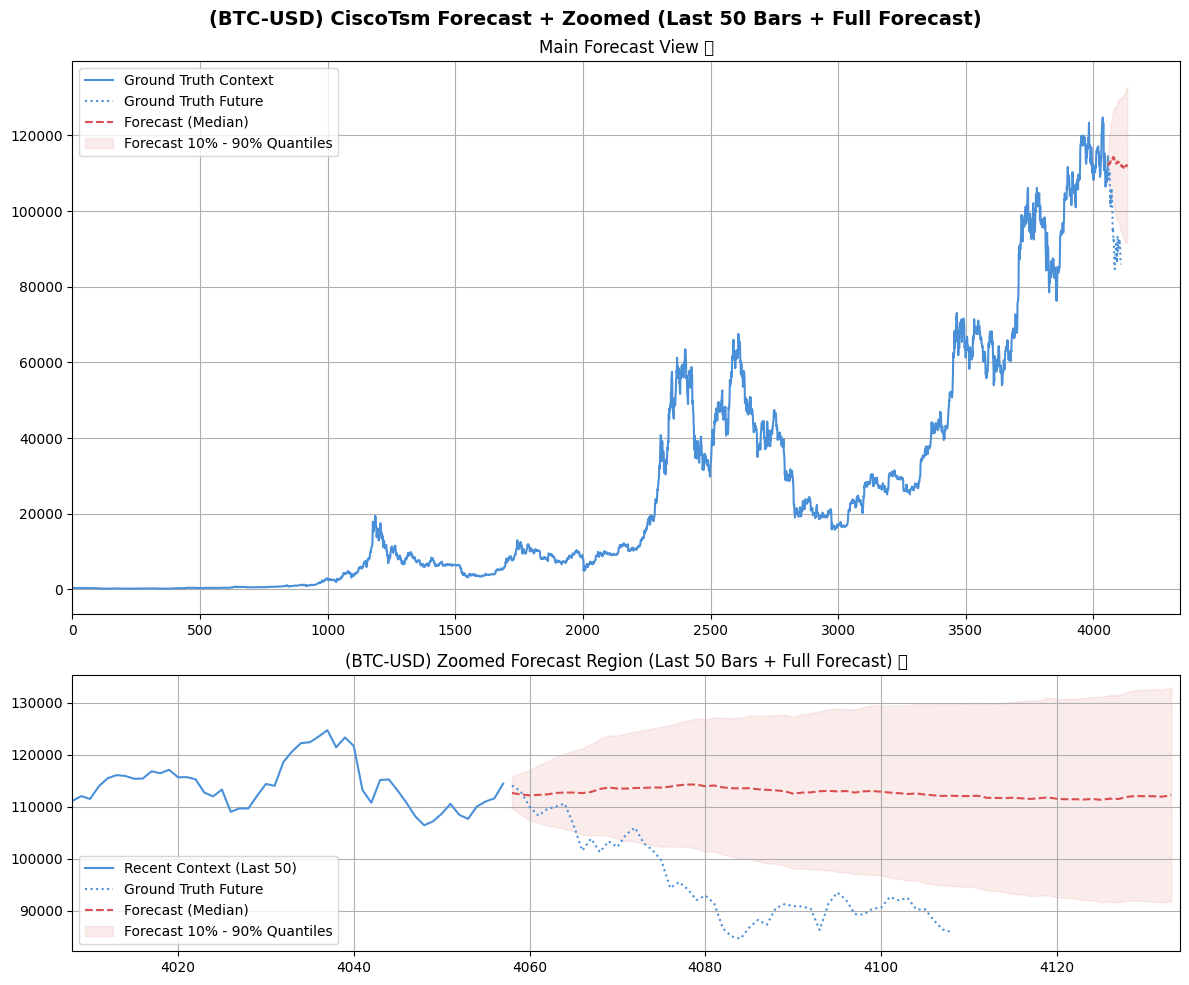

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for BTC-USD completed successfully.
--- 🏁 Run for BTC-USD concluded. ---


In [65]:
TICKER = 'BTC-USD'
run_single_asset_forecast(TICKER)

# ETH USD


--- 🏭 Starting CiscoTsmModel run for Ticker: ETH-USD (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for ETH-USD (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for ETH-USD from yfinance...


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 2960
Context length: 2909. Future length: 51.
➡️ Non-overlapping forecast: forecast_x starts at 2909


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


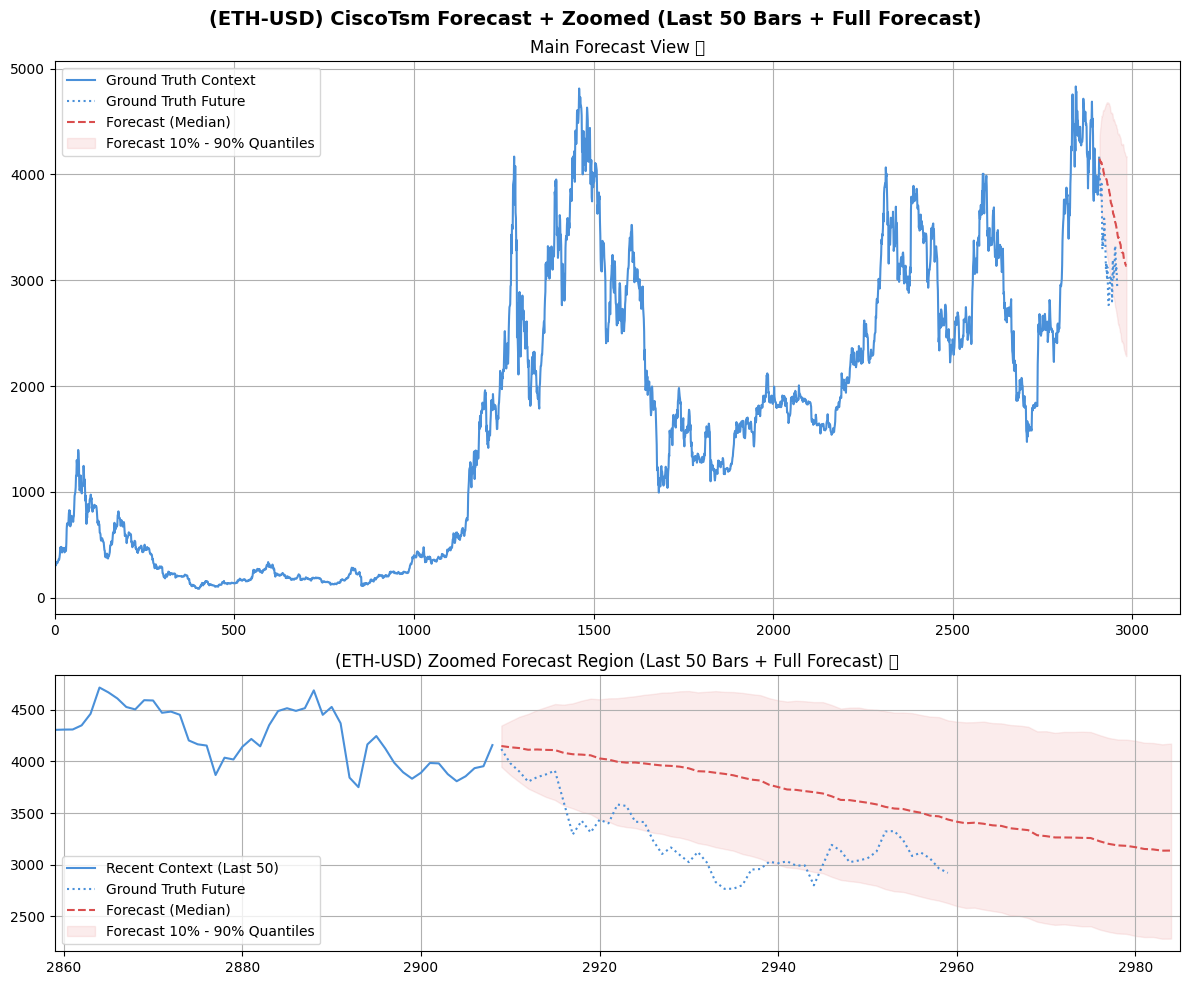

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for ETH-USD completed successfully.
--- 🏁 Run for ETH-USD concluded. ---


In [66]:
TICKER = 'ETH-USD'
run_single_asset_forecast(TICKER)

# SOL USD


--- 🏭 Starting CiscoTsmModel run for Ticker: SOL-USD (YFinance) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for SOL-USD (2012-01-01 to 2025-12-31).
The deriv setting is  False
📥 Loading data for SOL-USD from yfinance...
Loadded data from yfinance
******************************
Startiing predictions
******************************
Total data points: 2077
Context length: 2026. Future length: 51.


/tmp/ipykernel_274/4263523795.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(self.TICKER, start=self.START_DATE, end=self.END_DATE, progress=False)


➡️ Non-overlapping forecast: forecast_x starts at 2026


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


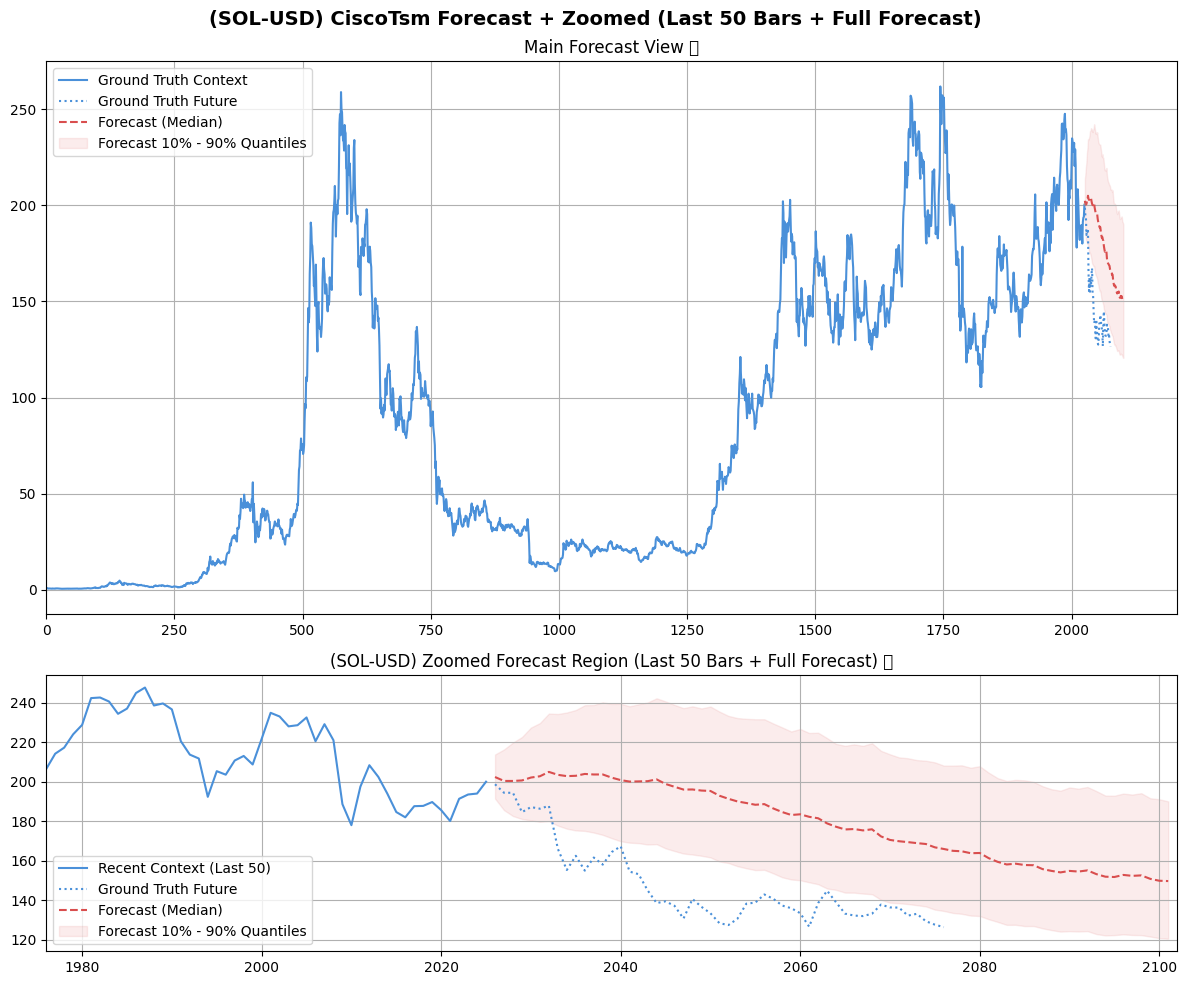

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for SOL-USD completed successfully.
--- 🏁 Run for SOL-USD concluded. ---


In [67]:
TICKER = 'SOL-USD'
run_single_asset_forecast(TICKER)

# Deriv Volatility 10 Index



#####################################################
Running Deriv Asset Forecast for R_10
#####################################################

--- 🏭 Starting CiscoTsmModel run for Ticker: R_10 (Deriv) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <coroutine object Connection.recv at 0x79a5e831be40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/websockets/asyncio/connection.py", line 303, in recv
    return await self.recv_messages.get(decode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/websockets/asyncio/messages.py", line 159, in get
    frame = await self.frames.get(not self.closed)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/websockets/asyncio/messages.py", line 53, in get
    self.get_waiter.cancel()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 762, in call_soon
    self._check_closed()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 520, in _check_closed
    raise RuntimeError('Event loop is closed')
RuntimeError: Event loop is closed


🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for R_10 (2012-01-01 to 2025-12-31).
The deriv setting is  True
📥 Fetching 1-minute OHLC data for R_10 from Deriv...
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
✅ Authorized! Login ID: VRTC1925073
⏳ Requesting 5000 1-minute candles for R_10...
✅ Loaded 5000 candles.
Loadded data from deriv
******************************
Startiing predictions
******************************
Total data points: 5000
Context length: 4940. Future length: 60.
➡️ Non-overlapping forecast: forecast_x starts at 4940


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


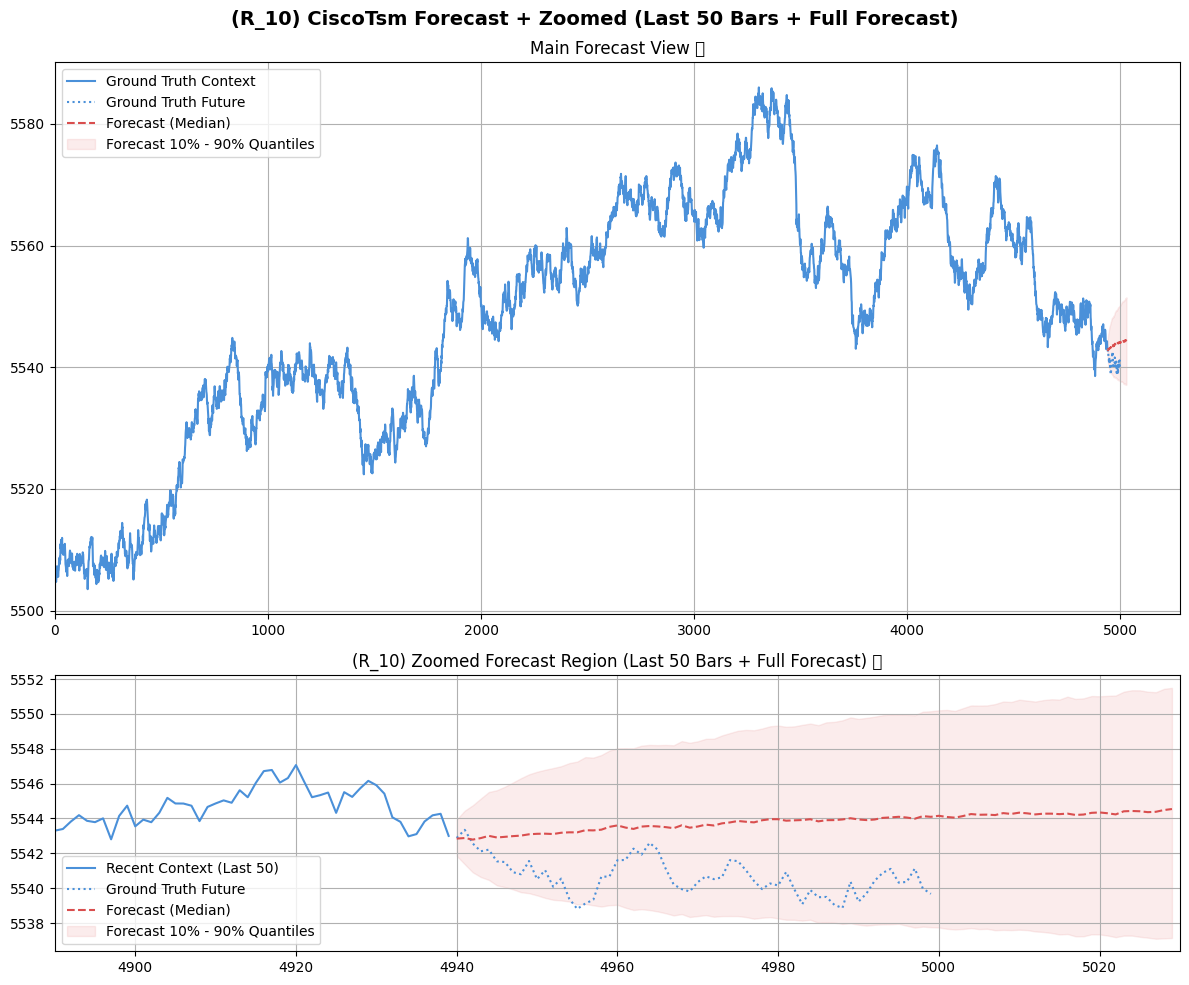

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for R_10 completed successfully.
--- 🏁 Run for R_10 concluded. ---


In [72]:
DERIV_TICKER = "R_10"         # 📈 Volatility 100 Index (VIX equivalent)
OHLC_GRANULARITY = 60       # 📅 1 Day in seconds (to mimic daily close data)
OHLC_COUNT = 5000              # 💾 Number of historical daily candles to fetch

print("\n\n#####################################################")
print(f"Running Deriv Asset Forecast for {DERIV_TICKER}")
print("#####################################################")

run_single_asset_forecast(
    ticker=DERIV_TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    deriv=True,                 # *** THIS IS THE KEY CHANGE ***
    count=OHLC_COUNT,
    tf=OHLC_GRANULARITY,
    prediction_length=90,       
    future_length=60,
)



#####################################################
Running Deriv Asset Forecast for CRASH1000
#####################################################

--- 🏭 Starting CiscoTsmModel run for Ticker: CRASH1000 (Deriv) ---


Exception ignored in: <coroutine object Connection.recv at 0x79a4d7277740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/websockets/asyncio/connection.py", line 303, in recv
    return await self.recv_messages.get(decode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/websockets/asyncio/messages.py", line 159, in get
    frame = await self.frames.get(not self.closed)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/websockets/asyncio/messages.py", line 53, in get
    self.get_waiter.cancel()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 762, in call_soon
    self._check_closed()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 520, in _check_closed
    raise RuntimeError('Event loop is closed')
RuntimeError: Event loop is closed


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for CRASH1000 (2012-01-01 to 2025-12-31).
The deriv setting is  True
📥 Fetching 1-minute OHLC data for CRASH1000 from Deriv...
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
✅ Authorized! Login ID: VRTC1925073
⏳ Requesting 5000 1-minute candles for CRASH1000...
✅ Loaded 5000 candles.
Loadded data from deriv
******************************
Startiing predictions
******************************
Total data points: 5000
Context length: 4940. Future length: 60.
➡️ Non-overlapping forecast: forecast_x starts at 4940


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


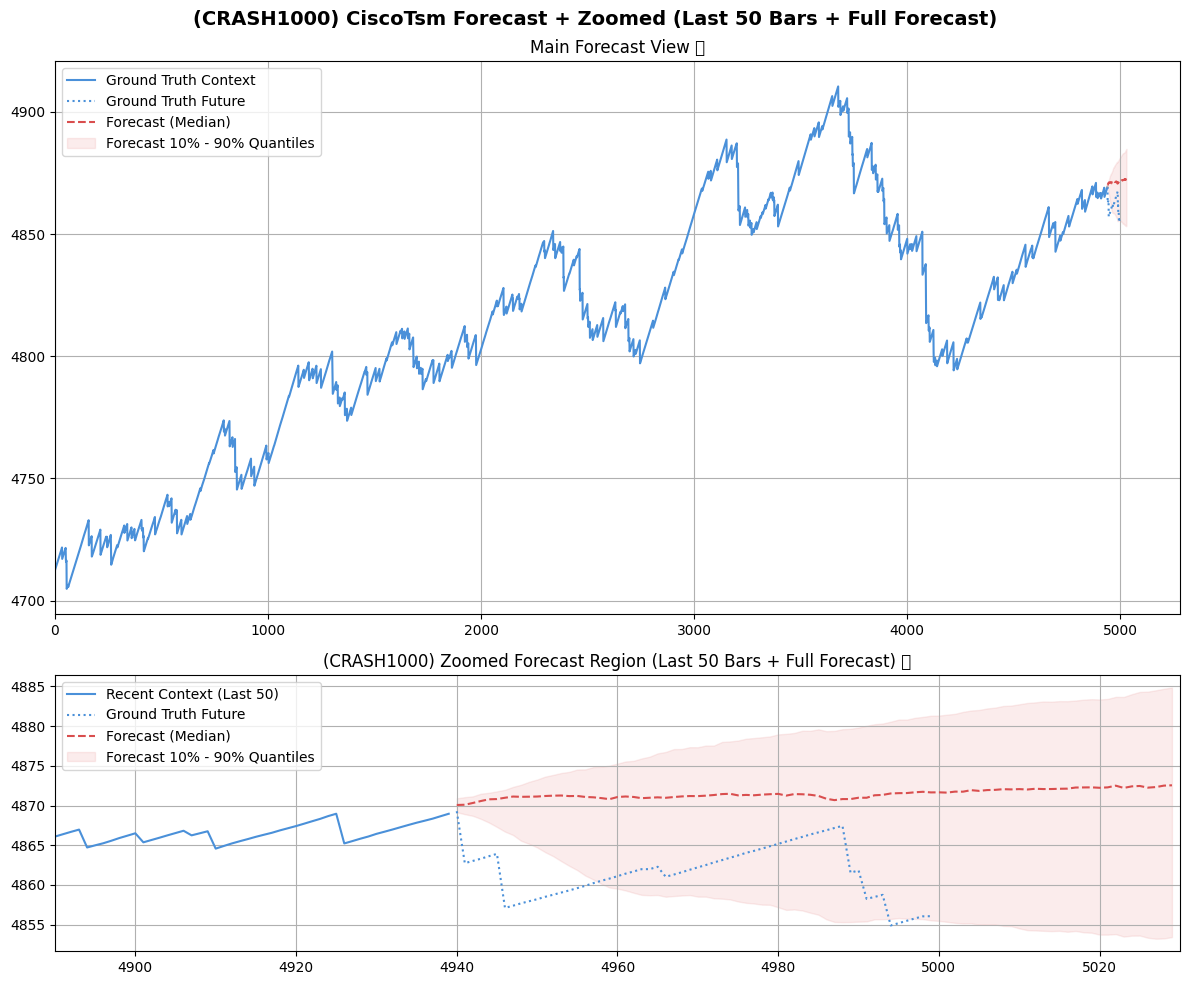

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for CRASH1000 completed successfully.
--- 🏁 Run for CRASH1000 concluded. ---


In [75]:
DERIV_TICKER = "CRASH1000"         # 📈 Volatility 100 Index (VIX equivalent)
OHLC_GRANULARITY = 60       # 📅 1 Day in seconds (to mimic daily close data)
OHLC_COUNT = 5000              # 💾 Number of historical daily candles to fetch

print("\n\n#####################################################")
print(f"Running Deriv Asset Forecast for {DERIV_TICKER}")
print("#####################################################")

run_single_asset_forecast(
    ticker=DERIV_TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    deriv=True,                 # *** THIS IS THE KEY CHANGE ***
    count=OHLC_COUNT,
    tf=OHLC_GRANULARITY,
    prediction_length=90,       
    future_length=60,
)



#####################################################
Running Deriv Asset Forecast for BOOM1000
#####################################################

--- 🏭 Starting CiscoTsmModel run for Ticker: BOOM1000 (Deriv) ---


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

🤖 CiscoTsmMR model loaded successfully.

✨ Initialized CiscoTsm Forecaster for BOOM1000 (2012-01-01 to 2025-12-31).
The deriv setting is  True
📥 Fetching 1-minute OHLC data for BOOM1000 from Deriv...
⚠️ Bypassing main thread's running event loop (Kaggle/Jupyter fix). Fetching data in a separate thread...
🔗 Connecting securely to Deriv WebSocket...
✅ Authorized! Login ID: VRTC1925073
⏳ Requesting 5000 1-minute candles for BOOM1000...
✅ Loaded 5000 candles.
Loadded data from deriv
******************************
Startiing predictions
******************************
Total data points: 5000
Context length: 4940. Future length: 60.
➡️ Non-overlapping forecast: forecast_x starts at 4940


/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_274/4263523795.py:249: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


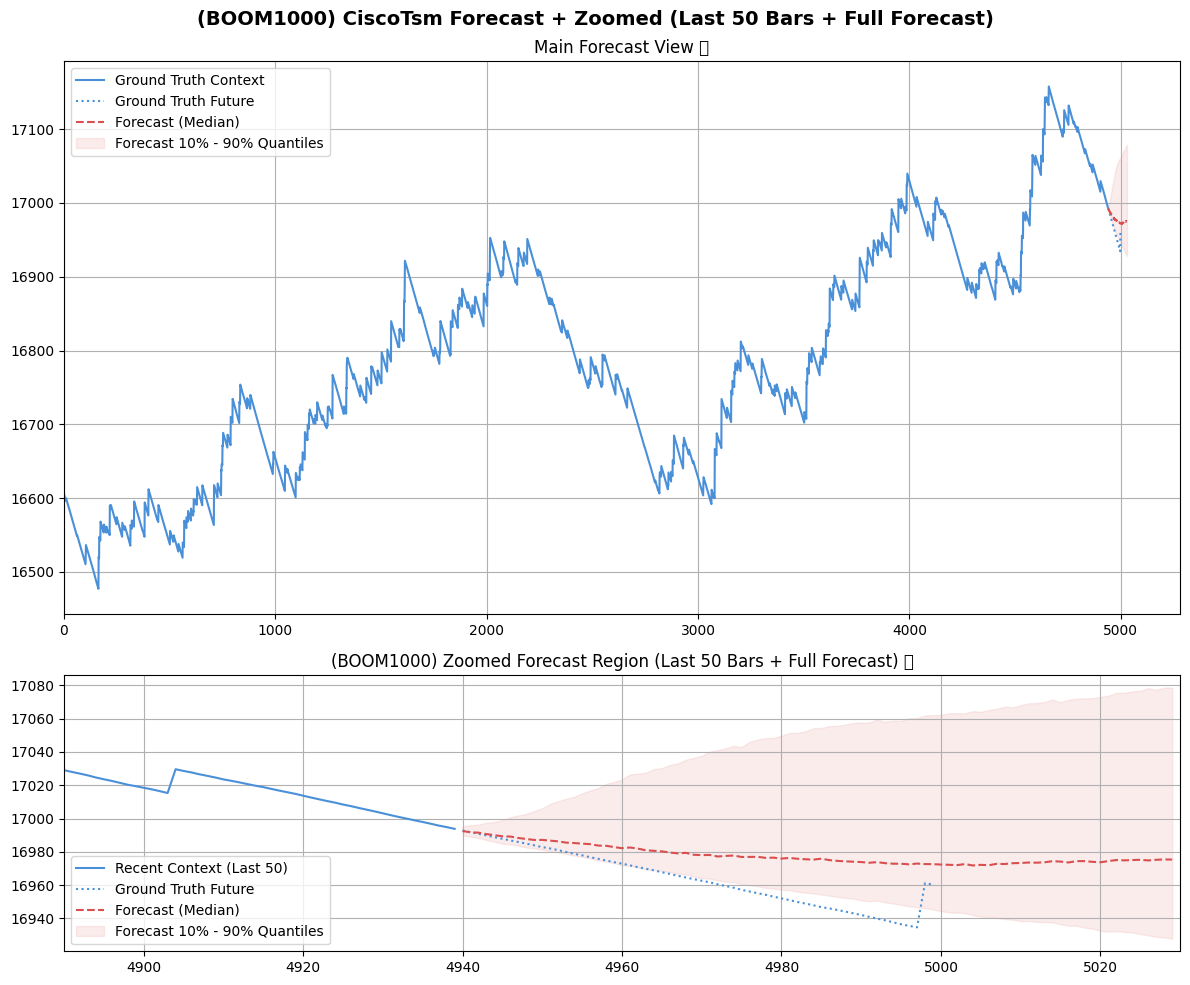

✅ Plotted main and zoomed forecast views (last 50 bars + full forecast) successfully! 🚀
✅ Run for BOOM1000 completed successfully.
--- 🏁 Run for BOOM1000 concluded. ---


In [76]:
DERIV_TICKER = "BOOM1000"         # 📈 Volatility 100 Index (VIX equivalent)
OHLC_GRANULARITY = 60       # 📅 1 Day in seconds (to mimic daily close data)
OHLC_COUNT = 5000              # 💾 Number of historical daily candles to fetch

print("\n\n#####################################################")
print(f"Running Deriv Asset Forecast for {DERIV_TICKER}")
print("#####################################################")

run_single_asset_forecast(
    ticker=DERIV_TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    deriv=True,                 # *** THIS IS THE KEY CHANGE ***
    count=OHLC_COUNT,
    tf=OHLC_GRANULARITY,
    prediction_length=90,       
    future_length=60,
)